> Assign -1 for similarity if there is missing in either of the Fields 
(No additional columns)

In [2]:
import pandas as pd
import numpy as np
import libact
from libact.models import SVM
from libact.query_strategies import QUIRE, UncertaintySampling, RandomSampling, ActiveLearningByLearning, HintSVM
import warnings
import matplotlib.pyplot as plt
from libact.models import SklearnAdapter
from sklearn import tree
import seaborn as sbn
import time
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier

In [3]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [4]:
from Utils import *
from Similarity import *

- Get the Data

In [5]:
phone_path ='/Users/bengikoseoglu/Documents/Masters/Semester4/Thesis/Notebooks/1_Merging/phone_merged.csv'
phone_result=pd.read_csv(phone_path)
phone_result.head()

,Unnamed: 0,id_webpage,match,page_brand,page_mpn,page_display_size,page_url,page_rear_cam_resolution,page_warc,page_color,page_product_code,page_ram,page_computer_operating_system,page_phone_type,page_processor_type,page_memory,page_front_cam_resolution,page_dimensions,page_display_resolution,page_weight,page_wattage,page_product_type,page_phone_carrier,page_depth,page_width,page_height,page_product_gtin,page_manufacturer,page_modelnum,page_body_material,cat_package_height,cat_computer_operating_system,cat_body_material,cat_display_size,cat_weight,cat_product_code,cat_core_count,cat_processor_type,cat_wattage,cat_modelnum,cat_mpn,cat_color,cat_memory,cat_power_supply,cat_rear_cam_resolution,cat_product_gtin,cat_depth,cat_phone_type,cat_phone_carrier,cat_product_type,cat_width,cat_front_cam_resolution,cat_brand,cat_ram,cat_manufacturer,cat_voltage,cat_display_resolution,cat_dimensions,cat_height,prodcat_product_name,prodcat_id,id
0,0,node5fd6d025f29b89ff319c853d0e33744,0,htc,NaN,5 in,http://www.ebay.com/itm/blocked-htc-one-m9-32g...,20.0mp,ebay.com0.warc.nq.gz,gold on silver,NaN,NaN,NaN,one m9,NaN,32gb,NaN,NaN,NaN,5.54 oz,2840mah,smartphone,t-mobile,0.38 in,2.74 in,5.69 in.,NaN,NaN,NaN,NaN,NaN,ios 8,"stainless steel, glass, anodized aluminum",4.7 in,4.5 oz,NaN,NaN,a8,NaN,NaN,mg642ll/a,space gray|silver|gold,64gb,NaN,8 mp,00885909950997,0.3 in,iphone 6,verizon wireless,smartphone,2.6 in,1.2 mp,apple,1gb,NaN,1810 mah,750 x 1334 pixels,138.1 x 67 x 6.9 mm,5.4 in,iphone 6 64gb,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,3fb875ca-a0e6-11e9-85f7-d0817aaa94da
1,1,nodee9affe60fbe185b64feb5811d2e43159,0,htc,htc6535lvw,5 in,http://www.ebay.com/itm/works-perfect-htc-one-...,20 mp,ebay.com0.warc.nq.gz,gunmetal gray,NaN,NaN,NaN,m9,NaN,32gb,NaN,NaN,NaN,5.54 oz,2840mah,smartphone,verizon,0.38 in,2.74 in,5.69 in,NaN,NaN,NaN,NaN,NaN,ios 8,"stainless steel, glass, anodized aluminum",4.7 in,4.5 oz,NaN,NaN,a8,NaN,NaN,mg642ll/a,space gray|silver|gold,64gb,NaN,8 mp,00885909950997,0.3 in,iphone 6,verizon wireless,smartphone,2.6 in,1.2 mp,apple,1gb,NaN,1810 mah,750 x 1334 pixels,138.1 x 67 x 6.9 mm,5.4 in,iphone 6 64gb,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,3fb87822-a0e6-11e9-85f7-d0817aaa94da
2,2,nodeb1d0ceb9797fd339c5f7c04aa76a7af1,0,htc,6735a,5 in,http://www.ebay.com/itm/unlocked-htc-one-m9-32...,20 mp,ebay.com0.warc.nq.gz,gunmetal gray,NaN,NaN,NaN,one m9,NaN,32gb,NaN,NaN,NaN,5.54 oz,2840mah,smartphone,at&t,0.38 in,2.74 in,5.69 in,821793045111,NaN,NaN,NaN,NaN,ios 8,"stainless steel, glass, anodized aluminum",4.7 in,4.5 oz,NaN,NaN,a8,NaN,NaN,mg642ll/a,space gray|silver|gold,64gb,NaN,8 mp,00885909950997,0.3 in,iphone 6,verizon wireless,smartphone,2.6 in,1.2 mp,apple,1gb,NaN,1810 mah,750 x 1334 pixels,138.1 x 67 x 6.9 mm,5.4 in,iphone 6 64gb,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,3fb8787c-a0e6-11e9-85f7-d0817aaa94da
3,3,node12b450a88f0d6b897758f676414c61,0,htc,opja120,NaN,http://www.ebay.com/itm/refurbished-htc-one-m9...,NaN,ebay.com0.warc.nq.gz,gold,NaN,NaN,NaN,one m9,NaN,32gb,NaN,NaN,NaN,NaN,NaN,NaN,t-mobile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios 8,"stainless steel, glass, anodized aluminum",4.7 in,4.5 oz,NaN,NaN,a8,NaN,NaN,mg642ll/a,space gray|silver|gold,64gb,NaN,8 mp,00885909950997,0.3 in,iphone 6,verizon wireless,smartphone,2.6 in,1.2 mp,apple,1gb,NaN,1810 mah,750 x 1334 pixels,138.1 x 67 x 6.9 mm,5.4 in,iphone 6 64gb,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,3fb878b8-a0e6-11e9-85f7-d0817aaa94da
4,4,node9ace9d5daf49116fed3f11241dff6d,0,htc,ebay_htconem932gbgoldonsilverunlocked,5 in,http://www.ebay.com/itm/nice-factory-unlocked-...,20 mp,ebay.com0.warc.nq.gz,gold on silver,NaN,NaN,android,one m9,NaN,32gb,NaN,NaN,NaN,5.54 oz,2840mah,smartphone,unlocked,0.38 in,2.74 in,5.69 in,NaN,NaN,NaN,NaN,NaN,ios 8,"stainless steel, glass, anodized aluminum",4.7 in,4.5 oz,NaN,NaN,a8,NaN,NaN,mg642ll/a,space gray|silver|gold,64gb,NaN,8 mp,00885909950997,0.3 in,iphone 6,verizon wireless,smartphone,2.6 in,1.2 mp,apple,1gb,NaN,1810 mah,750 x 1334 pixels,138.1 x 67 x 6.9 mm,5.4 in,ipho

In [6]:
phone_result.shape

(21455, 62)

- Choose attributes

 not usable:
 Unnamed: 0
 id_webpage
 prodcat_id
 page_url
 page_warc 
 prodcat_product_name

 match

 no matches: 
 cat_voltage
 cat_package_height
 cat_core_count
 cat_power_supply

 page_product_type -> cat_product_type
 page_mpn -> cat_mpn
 page_brand -> cat_brand
 page_phone_type -> cat_product_type
 page_computer_operating_system -> cat_computer_operating_system
 page_memory -> cat_memory
 page_depth -> cat_depth
 page_product_grin -> cat_product_gtin
 page_rear_cam_resolution -> cat_rear_cam_resolution
 page_height -> cat_height
 page_phone_carrier -> cat_phone_carrier
 page_ram -> cat_ram
 page_dimensions -> cat_dimensions
 page_front_cam_resolution -> cat_front_cam_resolution
 page_body_material -> cat_body_material
 page_color -> cat_color
 page_display_size -> cat_display_size
 page_processor_type -> cat_processor_type
 page_weight -> cat_weight
 page_display_resolution -> cat_display_resolution
 page_width -> cat_width

 page_wattage -> cat_wattage (MISSING)
 page_product_code -> cat_product_code (MISSING)
 page_manufacturer -> cat_manufacturer (MISSING)
 page_modelnum -> cat_modelnum. (MISSING)


In [7]:
# columns that only exist in pages
only_page_columns=[]
print(len(only_page_columns))

0


In [8]:
# columns that only exist in catalog
only_cat_columns=['cat_core_count','cat_package_height','cat_power_supply','cat_voltage']
print(len(only_cat_columns))

4


In [9]:
# columns that are ids, target and matching attributes
matches=['id_webpage','prodcat_id','page_url','page_warc','prodcat_product_name','match','cat_product_gtin', 'page_product_gtin', 'cat_modelnum','page_modelnum', 'cat_product_type', 'page_product_type', 'cat_phone_type','page_phone_type', 'cat_mpn','page_mpn','cat_brand','page_brand','cat_manufacturer','page_manufacturer','cat_computer_operating_system','page_computer_operating_system','cat_height', 'page_height', 'cat_body_material','page_body_material','cat_display_size','page_display_size','cat_weight','page_weight','cat_product_code','page_product_code', 'cat_color', 'page_color','cat_memory','page_memory','cat_rear_cam_resolution','page_rear_cam_resolution','cat_front_cam_resolution', 'page_front_cam_resolution','cat_display_resolution','page_display_resolution','cat_depth','page_depth',  'cat_width','page_width','cat_phone_carrier', 'page_phone_carrier','cat_ram', 'page_ram', 'cat_dimensions','page_dimensions','cat_wattage','page_wattage','cat_processor_type','page_processor_type']
print(len(matches))

56


In [10]:
cols_inorder= matches.copy()
cols_inorder.extend(only_cat_columns)
cols_inorder.extend(only_page_columns)
phone_result_sub=phone_result[cols_inorder]
phone_result_sub.head()

,id_webpage,prodcat_id,page_url,page_warc,prodcat_product_name,match,cat_product_gtin,page_product_gtin,cat_modelnum,page_modelnum,cat_product_type,page_product_type,cat_phone_type,page_phone_type,cat_mpn,page_mpn,cat_brand,page_brand,cat_manufacturer,page_manufacturer,cat_computer_operating_system,page_computer_operating_system,cat_height,page_height,cat_body_material,page_body_material,cat_display_size,page_display_size,cat_weight,page_weight,cat_product_code,page_product_code,cat_color,page_color,cat_memory,page_memory,cat_rear_cam_resolution,page_rear_cam_resolution,cat_front_cam_resolution,page_front_cam_resolution,cat_display_resolution,page_display_resolution,cat_depth,page_depth,cat_width,page_width,cat_phone_carrier,page_phone_carrier,cat_ram,page_ram,cat_dimensions,page_dimensions,cat_wattage,page_wattage,cat_processor_type,page_processor_type,cat_core_count,cat_package_height,cat_power_supply,cat_voltage
0,node5fd6d025f29b89ff319c853d0e33744,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,http://www.ebay.com/itm/blocked-htc-one-m9-32g...,ebay.com0.warc.nq.gz,iphone 6 64gb,0,00885909950997,NaN,NaN,NaN,smartphone,smartphone,iphone 6,one m9,mg642ll/a,NaN,apple,htc,NaN,NaN,ios 8,NaN,5.4 in,5.69 in.,"stainless steel, glass, anodized aluminum",NaN,4.7 in,5 in,4.5 oz,5.54 oz,NaN,NaN,space gray|silver|gold,gold on silver,64gb,32gb,8 mp,20.0mp,1.2 mp,NaN,750 x 1334 pixels,NaN,0.3 in,0.38 in,2.6 in,2.74 in,verizon wireless,t-mobile,1gb,NaN,138.1 x 67 x 6.9 mm,NaN,NaN,2840mah,a8,NaN,NaN,NaN,NaN,1810 mah
1,nodee9affe60fbe185b64feb5811d2e43159,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,http://www.ebay.com/itm/works-perfect-htc-one-...,ebay.com0.warc.nq.gz,iphone 6 64gb,0,00885909950997,NaN,NaN,NaN,smartphone,smartphone,iphone 6,m9,mg642ll/a,htc6535lvw,apple,htc,NaN,NaN,ios 8,NaN,5.4 in,5.69 in,"stainless steel, glass, anodized aluminum",NaN,4.7 in,5 in,4.5 oz,5.54 oz,NaN,NaN,space gray|silver|gold,gunmetal gray,64gb,32gb,8 mp,20 mp,1.2 mp,NaN,750 x 1334 pixels,NaN,0.3 in,0.38 in,2.6 in,2.74 in,verizon wireless,verizon,1gb,NaN,138.1 x 67 x 6.9 mm,NaN,NaN,2840mah,a8,NaN,NaN,NaN,NaN,1810 mah
2,nodeb1d0ceb9797fd339c5f7c04aa76a7af1,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,http://www.ebay.com/itm/unlocked-htc-one-m9-32...,ebay.com0.warc.nq.gz,iphone 6 64gb,0,00885909950997,821793045111,NaN,NaN,smartphone,smartphone,iphone 6,one m9,mg642ll/a,6735a,apple,htc,NaN,NaN,ios 8,NaN,5.4 in,5.69 in,"stainless steel, glass, anodized aluminum",NaN,4.7 in,5 in,4.5 oz,5.54 oz,NaN,NaN,space gray|silver|gold,gunmetal gray,64gb,32gb,8 mp,20 mp,1.2 mp,NaN,750 x 1334 pixels,NaN,0.3 in,0.38 in,2.6 in,2.74 in,verizon wireless,at&t,1gb,NaN,138.1 x 67 x 6.9 mm,NaN,NaN,2840mah,a8,NaN,NaN,NaN,NaN,1810 mah
3,node12b450a88f0d6b897758f676414c61,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,http://www.ebay.com/itm/refurbished-htc-one-m9...,ebay.com0.warc.nq.gz,iphone 6 64gb,0,00885909950997,NaN,NaN,NaN,smartphone,NaN,iphone 6,one m9,mg642ll/a,opja120,apple,htc,NaN,NaN,ios 8,NaN,5.4 in,NaN,"stainless steel, glass, anodized aluminum",NaN,4.7 in,NaN,4.5 oz,NaN,NaN,NaN,space gray|silver|gold,gold,64gb,32gb,8 mp,NaN,1.2 mp,NaN,750 x 1334 pixels,NaN,0.3 in,NaN,2.6 in,NaN,verizon wireless,t-mobile,1gb,NaN,138.1 x 67 x 6.9 mm,NaN,NaN,NaN,a8,NaN,NaN,NaN,NaN,1810 mah
4,node9ace9d5daf49116fed3f11241dff6d,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,http://www.ebay.com/itm/nice-factory-unlocked-...,ebay.com0.warc.nq.gz,iphone 6 64gb,0,00885909950997,NaN,NaN,NaN,smartphone,smartphone,iphone 6,one m9,mg642ll/a,ebay_htconem932gbgoldonsilverunlocked,apple,htc,NaN,NaN,ios 8,android,5.4 in,5.69 in,"stainless steel, glass, anodized aluminum",NaN,4.7 in,5 in,4.5 oz,5.54 oz,NaN,NaN,space gray|silver|gold,gold on silver,64gb,32gb,8 mp,20 mp,1.2 mp,NaN,750 x 1334 pixels,NaN,0.3 in,0.38 in,2.6 in,2.74 in,verizon wireless,unlocked,1gb,NaN,138.1 x 67 x 6.9 mm,NaN,NaN,2840mah,a8,NaN,NaN,NaN,NaN,1810 mah


In [11]:
print(len(phone_result_sub.columns))
print(len(set(phone_result_sub.columns)))

60
60


- Look at missing values

In [12]:
phone_result_stat=get_stats_table(phone_result_sub,only_page_columns,only_cat_columns)
phone_result_stat.to_excel('phone_result_stats.xlsx')
print(phone_result_stat.shape)

(60, 8)


In [13]:
phone_result_stat

,count,no_unique,no_missing,percent_missing,only in page,only in catalog,most_freq,no_most_freq
column_name,,,,,,,,
id_webpage,21455,447,0,0.000,0,0,node8d1edb72e9dc344acf5099fe846379da,48
prodcat_id,21455,48,0,0.000,0,0,389d2228-5b6b-4f6b-969c-27b245f4c233,447
page_url,21455,447,0,0.000,0,0,http://www.tesco.com/direct/iphone-6s-64gb-sil...,48
page_warc,21455,37,0,0.000,0,0,ebay.com0.warc.nq.gz,9215
prodcat_product_name,21455,48,0,0.000,0,0,iphone 4s 8gb,447
match,21455,2,0,0.000,0,0,0,21237
cat_product_gtin,17432,39,4023,0.188,0,0,nan,4023
page_product_gtin,1488,25,19967,0.931,0,0,nan,19967
cat_modelnum,0,0,21455,1.000,0,0,nan,21455


- Drop missing values

In [14]:
full_missing_columns=list(phone_result_stat[phone_result_stat['percent_missing']==1].index)
print(full_missing_columns)

['cat_modelnum', 'cat_manufacturer', 'cat_product_code', 'cat_wattage', 'cat_package_height', 'cat_power_supply']


In [15]:
# find missing values correspodence in pages and category
page_col_drop=['page_'+i[4:] for i in full_missing_columns]
cat_col_drop=['cat_'+i[4:] for i in full_missing_columns]
cat_col_drop.extend(page_col_drop)
print(cat_col_drop)

['cat_modelnum', 'cat_manufacturer', 'cat_product_code', 'cat_wattage', 'cat_package_height', 'cat_power_supply', 'page_modelnum', 'page_manufacturer', 'page_product_code', 'page_wattage', 'page_package_height', 'page_power_supply']


In [16]:
# check whether every column exists
df_columns=list(phone_result_sub.columns)
new_drop=[]
for i in cat_col_drop:
    if(i in df_columns):
        new_drop.append(i)
new_drop

['cat_modelnum',
 'cat_manufacturer',
 'cat_product_code',
 'cat_wattage',
 'cat_package_height',
 'cat_power_supply',
 'page_modelnum',
 'page_manufacturer',
 'page_product_code',
 'page_wattage']

In [17]:
# actually drop them
phone_result_sub=phone_result_sub.drop(new_drop,axis=1)
print(phone_result_sub.shape)
print(phone_result_sub.columns)

(21455, 50)
Index(['id_webpage', 'prodcat_id', 'page_url', 'page_warc',
       'prodcat_product_name', 'match', 'cat_product_gtin',
       'page_product_gtin', 'cat_product_type', 'page_product_type',
       'cat_phone_type', 'page_phone_type', 'cat_mpn', 'page_mpn', 'cat_brand',
       'page_brand', 'cat_computer_operating_system',
       'page_computer_operating_system', 'cat_height', 'page_height',
       'cat_body_material', 'page_body_material', 'cat_display_size',
       'page_display_size', 'cat_weight', 'page_weight', 'cat_color',
       'page_color', 'cat_memory', 'page_memory', 'cat_rear_cam_resolution',
       'page_rear_cam_resolution', 'cat_front_cam_resolution',
       'page_front_cam_resolution', 'cat_display_resolution',
       'page_display_resolution', 'cat_depth', 'page_depth', 'cat_width',
       'page_width', 'cat_phone_carrier', 'page_phone_carrier', 'cat_ram',
       'page_ram', 'cat_dimensions', 'page_dimensions', 'cat_processor_type',
       'page_processor_typ

- Drop variables only in the categories, if they still exist

In [18]:
# check whether only category columns are still exist or not
df_columns=list(phone_result_sub.columns)
new_drop=[]
for i in only_cat_columns:
    if(i in df_columns):
        new_drop.append(i)
new_drop

['cat_core_count', 'cat_voltage']

In [19]:
phone_result_sub=phone_result_sub.drop(new_drop,axis=1)
print(phone_result_sub.shape)

(21455, 48)


- Drop unneccesary ids

In [20]:
# drop further ids
drop_2=['page_url', 'page_warc','prodcat_product_name']
phone_result_sub=phone_result_sub.drop(drop_2,axis=1)
print(phone_result_sub.shape)

(21455, 45)


- calculate similarities (jaccard, levenstein, jaro-winkler)

In [21]:
page_columns=get_clean_collist(phone_result_sub, 'page')
cat_columns=get_clean_collist(phone_result_sub, 'cat')
jac_columns_el=get_clean_collist(phone_result_sub, 'jac')
lev_columns_el =get_clean_collist(phone_result_sub, 'lev')
jaro_columns_el =get_clean_collist(phone_result_sub, 'jaro')
p_result_nomiss=calculate_similarities_option4(phone_result_sub,page_columns,cat_columns,jac_columns_el,lev_columns_el,jaro_columns_el)
p_result_nomiss.head()

,id_webpage,prodcat_id,match,cat_product_gtin,page_product_gtin,cat_product_type,page_product_type,cat_phone_type,page_phone_type,cat_mpn,page_mpn,cat_brand,page_brand,cat_computer_operating_system,page_computer_operating_system,cat_height,page_height,cat_body_material,page_body_material,cat_display_size,page_display_size,cat_weight,page_weight,cat_color,page_color,cat_memory,page_memory,cat_rear_cam_resolution,page_rear_cam_resolution,cat_front_cam_resolution,page_front_cam_resolution,cat_display_resolution,page_display_resolution,cat_depth,page_depth,cat_width,page_width,cat_phone_carrier,page_phone_carrier,cat_ram,page_ram,cat_dimensions,page_dimensions,cat_processor_type,page_processor_type,jac_product_gtin,lev_product_gtin,jaro_product_gtin,jac_product_type,lev_product_type,jaro_product_type,jac_phone_type,lev_phone_type,jaro_phone_type,jac_mpn,lev_mpn,jaro_mpn,jac_brand,lev_brand,jaro_brand,jac_computer_operating_system,lev_computer_operating_system,jaro_computer_operating_system,jac_height,lev_height,jaro_height,jac_body_material,lev_body_material,jaro_body_material,jac_display_size,lev_display_size,jaro_display_size,jac_weight,lev_weight,jaro_weight,jac_color,lev_color,jaro_color,jac_memory,lev_memory,jaro_memory,jac_rear_cam_resolution,lev_rear_cam_resolution,jaro_rear_cam_resolution,jac_front_cam_resolution,lev_front_cam_resolution,jaro_front_cam_resolution,jac_display_resolution,lev_display_resolution,jaro_display_resolution,jac_depth,lev_depth,jaro_depth,jac_width,lev_width,jaro_width,jac_phone_carrier,lev_phone_carrier,jaro_phone_carrier,jac_ram,lev_ram,jaro_ram,jac_dimensions,lev_dimensions,jaro_dimensions,jac_processor_type,lev_processor_type,jaro_processor_type
0,node5fd6d025f29b89ff319c853d0e33744,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,0,00885909950997,NaN,smartphone,smartphone,iphone 6,one m9,mg642ll/a,NaN,apple,htc,ios 8,NaN,5.4 in,5.69 in.,"stainless steel, glass, anodized aluminum",NaN,4.7 in,5 in,4.5 oz,5.54 oz,space gray|silver|gold,gold on silver,64gb,32gb,8 mp,20.0mp,1.2 mp,NaN,750 x 1334 pixels,NaN,0.3 in,0.38 in,2.6 in,2.74 in,verizon wireless,t-mobile,1gb,NaN,138.1 x 67 x 6.9 mm,NaN,a8,NaN,-1.0,-1.000000,-1.000000,1.0,1.0,1.0,0.142857,0.375,0.722222,-1.0,-1.000000,-1.000000,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.666667,0.84,-1.0,-1.0,-1.0,0.0,0.6,0.783333,0.0,0.666667,0.877778,0.285714,0.35,0.490476,0.0,0.5,0.666667,0.0,0.4,0.633333,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.833333,0.955556,0.0,0.666667,0.84,0.000000,0.2500,0.500000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,nodee9affe60fbe185b64feb5811d2e43159,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,0,00885909950997,NaN,smartphone,smartphone,iphone 6,m9,mg642ll/a,htc6535lvw,apple,htc,ios 8,NaN,5.4 in,5.69 in,"stainless steel, glass, anodized aluminum",NaN,4.7 in,5 in,4.5 oz,5.54 oz,space gray|silver|gold,gunmetal gray,64gb,32gb,8 mp,20 mp,1.2 mp,NaN,750 x 1334 pixels,NaN,0.3 in,0.38 in,2.6 in,2.74 in,verizon wireless,verizon,1gb,NaN,138.1 x 67 x 6.9 mm,NaN,a8,NaN,-1.0,-1.000000,-1.000000,1.0,1.0,1.0,0.000000,0.000,0.000000,0.0,0.200000,0.483333,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.666667,0.84,-1.0,-1.0,-1.0,0.0,0.6,0.783333,0.0,0.666667,0.877778,0.080000,0.20,0.565954,0.0,0.5,0.666667,0.0,0.6,0.783333,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.833333,0.955556,0.0,0.666667,0.84,0.384615,0.4375,0.894531,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,nodeb1d0ceb9797fd339c5f7c04aa76a7af1,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,0,00885909950997,821793045111,smartphone,smartphone,iphone 6,one m9,mg642ll/a,6735a,apple,htc,ios 8,NaN,5.4 in,5.69 in,"stainless steel, glass, anodized aluminum",NaN,4.7 in,5 in,4.5 oz,5.54 oz,space gray|silver|gold,gunmetal gray,64gb,32gb,8 mp,20 mp,1.2 mp,NaN,750 x 1334 pixels,NaN,0.3 in,0.38 in,2.6 in,2.74 in,verizon wireless,at&t,1gb,NaN,138.1 x 67 x 6.9 mm,NaN,a8,NaN,0.0,0.142857,0.373016,1.0,1.0,1.0,0.142857,0.375,0.722222,0.0,0.250000,0.550000,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.666667,0.84,-1.0,-1.0,-1.0,0.0,0.6,0.783333,0.0,0.666667,0.877778,0.080000

In [22]:
df2=p_result_nomiss.copy()

In [23]:
cols_all = jac_columns_el.copy()
cols_all.extend(lev_columns_el)
cols_all.extend(jaro_columns_el)
cols_all.append('match')

- Calculate heat matrix between target and different string matching methods

In [23]:
corrmat = p_result_nomiss.corr()

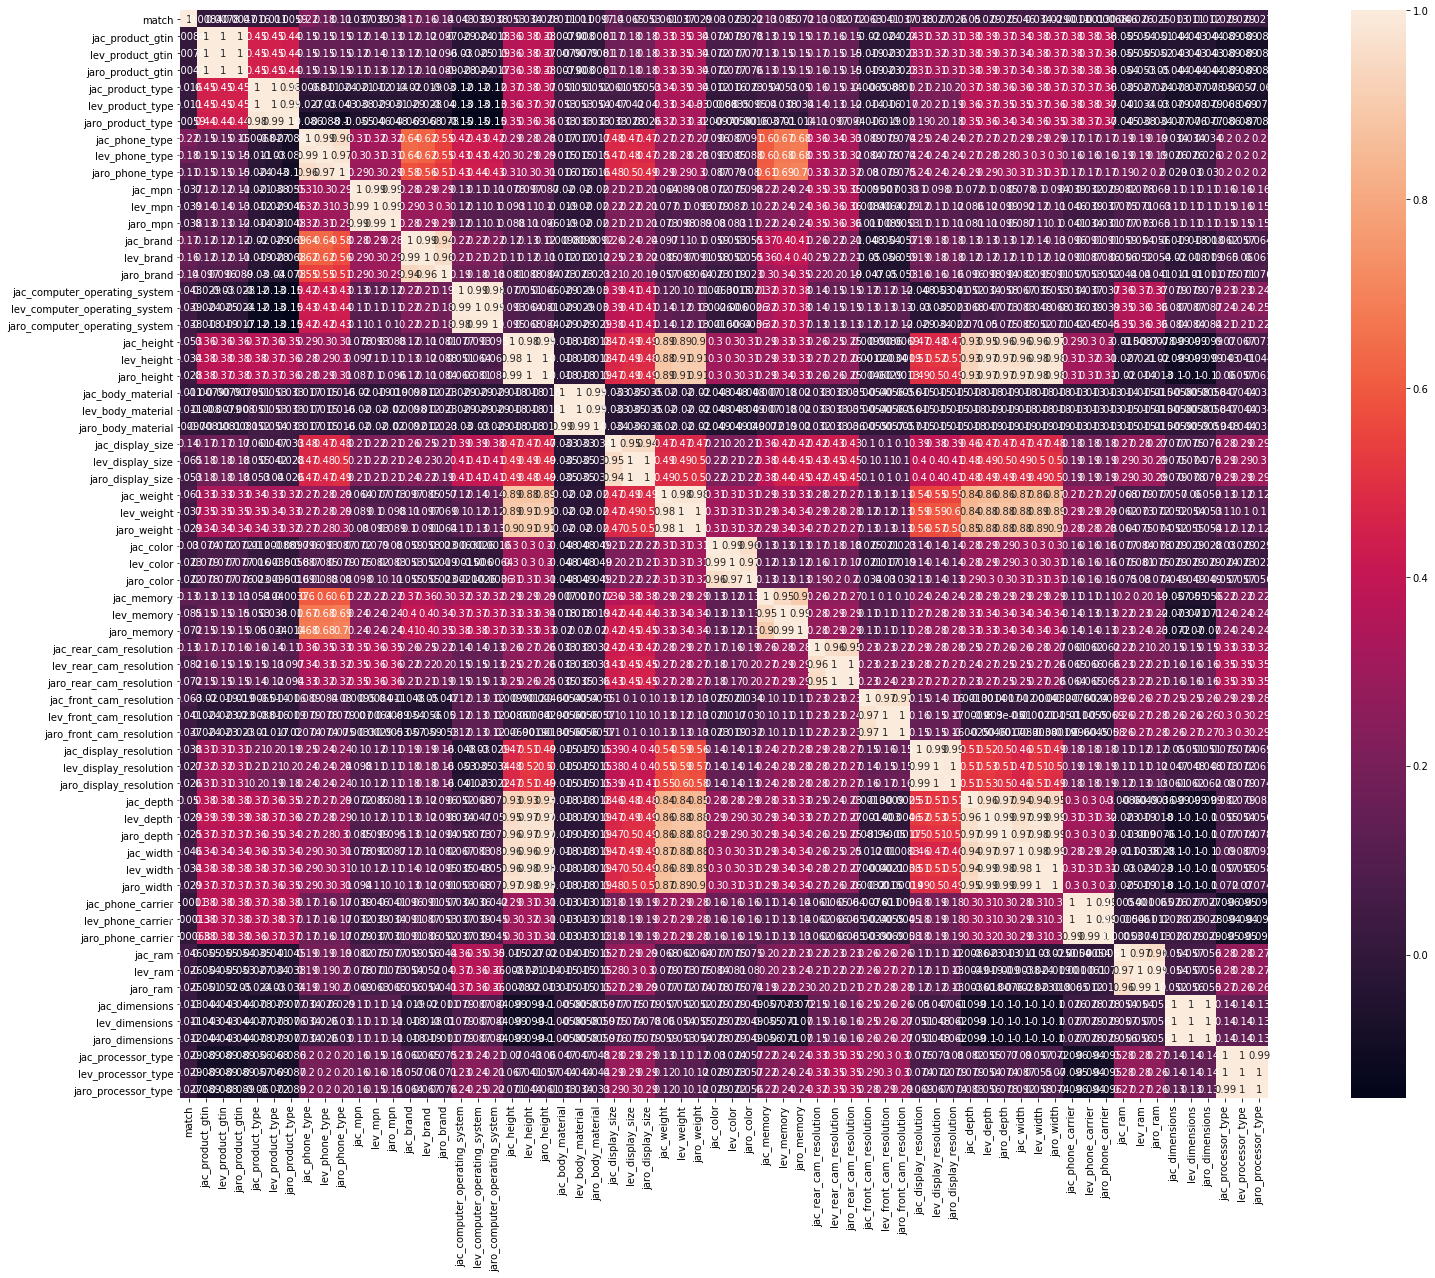

In [24]:
f, ax = plt.subplots(figsize=(30, 20))
sbn.heatmap(corrmat, vmax=1, cbar=True, annot=True, square=True)
plt.show()

# 1. USING ONLY JACCARD

- Modeling Parameters

In [34]:
cols = jac_columns_el.copy()

In [37]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

# filter the train and test according to its columns
X_train = np.array(pd.DataFrame(X_train).iloc[:,get_columns(cols_all, cols)])
X_test = np.array(pd.DataFrame(X_test).iloc[:,get_columns(cols_all, cols)])

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)


In [38]:
X_train.shape

(14374, 21)

In [39]:
df2.shape

(21455, 108)

In [40]:
run_=10
missing_option='opt4'
features='onlyjac'

- Model Results (pure)

In [41]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log, tn_log, fp_log, fn_log, tp_log = get_base_model_result(y_test, y_train, X_test, X_train, ls())
print(f1_score_log)
print(tn_log)
print(fp_log)
print(fn_log)
print(tp_log)

0.5333333333333333
7004
7
42
28


In [42]:
from sklearn.svm import SVC as support_vector
f1_score_svm, tn_svm, fp_svm, fn_svm, tp_svm = get_base_model_result(y_test, y_train, X_test, X_train, support_vector())
print(f1_score_svm)
print(tn_svm)
print(fp_svm)
print(fn_svm)
print(tp_svm)

0.13333333333333333
7011
0
65
5


In [43]:
from sklearn import tree
f1_score_dt, tn_dt, fp_dt, fn_dt, tp_dt = get_base_model_result(y_test, y_train, X_test, X_train, tree.DecisionTreeClassifier())
print(f1_score_dt)
print(tn_dt)
print(fp_dt)
print(fn_dt)
print(tp_dt)

0.7669172932330828
6999
12
19
51


In [44]:
f1_score_rf, tn_rf, fp_rf, fn_rf, tp_rf = get_base_model_result(y_test, y_train, X_test, X_train, RandomForestClassifier())
print(f1_score_rf)
print(tn_rf)
print(fp_rf)
print(fn_rf)
print(tp_rf)

0.7384615384615385
6999
12
22
48


In [36]:
X_train.shape

(14374, 63)

## 1.1. Random Sampling

In [42]:
q_type='random'

### 1.1.1. Logistic Regression

In [43]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5333333333333333
Current progress: 100.0 %
361.0838270187378


(0, 1)

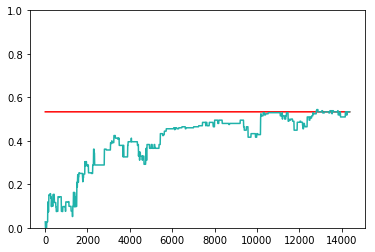

In [71]:
plt.plot(q_r_log, [f1_score_log] * (len(q_r_log)), '-r')
plt.plot(q_r_log, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)

### 1.1.2. Support Vector Machine

In [49]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.13333333333333333
Current progress: 100.0 %
431.1021270751953


(0, 1)

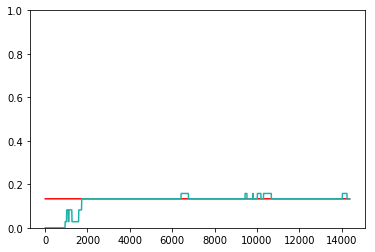

In [72]:
plt.plot(q_r_svm, [f1_score_svm] * (len(q_r_svm)), '-r')
plt.plot(q_r_svm, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 1.1.3. Decision Tree

In [51]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_dt, iter_r_dt, f1score_r_dt, tn_r_dt, fp_r_dt,fn_r_dt, tp_r_dt, k_r_dt, trn_dss_r_dt, label_holder_r_dt, asked_id_r_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7407407407407408
Current progress: 100.0 %
261.47235107421875


(0, 1)

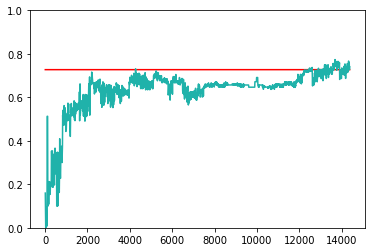

In [73]:
plt.plot(q_r_dt, [f1_score_dt] * (len(q_r_dt)), '-r')
plt.plot(q_r_dt, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 1.1.4. Random Forest Regression

In [53]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_rf, iter_r_rf, f1score_r_rf, tn_r_rf, fp_r_rf,fn_r_rf, tp_r_rf, k_r_rf, trn_dss_r_rf, label_holder_r_rf, asked_id_r_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7154471544715448
Current progress: 100.0 %
280.2314188480377


(0, 1)

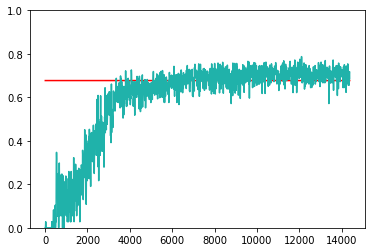

In [74]:
plt.plot(q_r_rf, [f1_score_rf] * (len(q_r_rf)), '-r')
plt.plot(q_r_rf, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

## 1.2. Uncertainity Sampling

In [32]:
q_type='uncertainity'

### 1.2.1. Logistic Regression

In [33]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5333333333333333
Current progress: 100.0 %
1175.1628789901733


(0, 1)

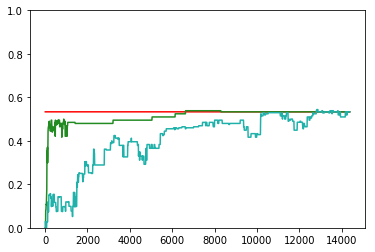

In [67]:
plt.plot(q_u_log, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 1.2.2. Support Vector Machine

In [35]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.13333333333333333
Current progress: 100.0 %
3397.2117490768433


(0, 1)

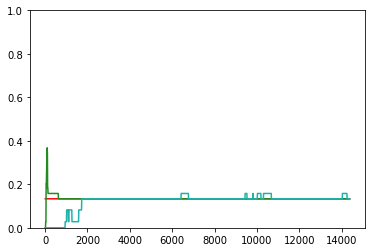

In [68]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 1.2.3. Decision Tree

In [37]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_dt, iter_u_dt, f1score_u_dt, tn_u_dt, fp_u_dt,fn_u_dt, tp_u_dt, k_u_dt, trn_dss_u_dt, label_holder_u_dt, asked_id_u_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7669172932330828
Current progress: 100.0 %
566.3512060642242


(0, 1)

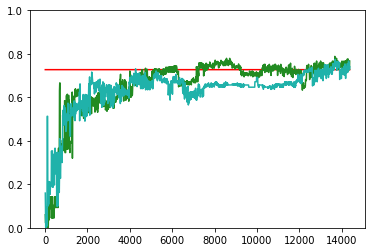

In [69]:
plt.plot(q_u_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_u_dt, f1score_u_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 1.2.4. Random Forest

In [39]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_rf, iter_u_rf, f1score_u_rf, tn_u_rf, fp_u_rf,fn_u_rf, tp_u_rf, k_u_rf, trn_dss_u_rf, label_holder_u_rf, asked_id_u_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7096774193548386
Current progress: 100.0 %
962.2441401481628


(0, 1)

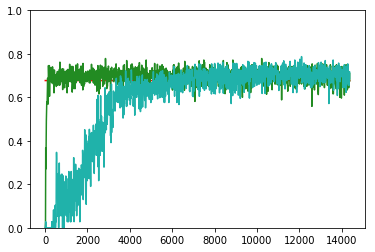

In [70]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_log, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

(all plot)

(0, 1)

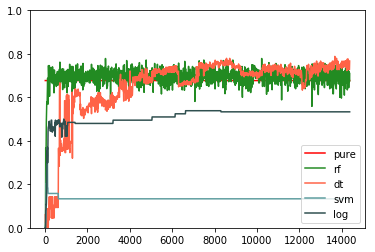

In [102]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_rf, f1score_u_dt, 'tomato')
plt.plot(q_u_rf, f1score_u_svm, 'cadetblue')
plt.plot(q_u_rf, f1score_u_log, 'darkslategray')

plt.legend((('pure','rf','dt','svm','log')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

## 1.3. Density Weighting

In [75]:
q_type='dns'

In [76]:
alg='log'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = DWUS(trn_ds, model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_dns_log, iter_dns_log, f1score_dns_log, tn_dns_log, fp_dns_log,fn_dns_log, tp_dns_log, k_dns_log, trn_dss_dns_log, label_holder_dns_log, asked_id_dns_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5333333333333333
Current progress: 100.0 %
35261.23097491264


(0, 1)

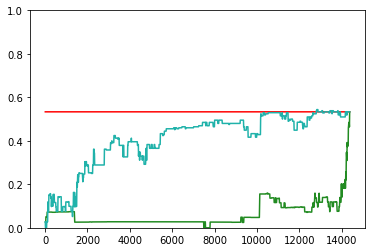

In [79]:
plt.plot(q_dns_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_dns_log, f1score_dns_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

## 1.3. Query by Committee

In [77]:
q_type='qbc'

### 1.3.1. Mix of all the models

In [78]:
alg='mixall'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
    SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM(),])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5333333333333333
Current progress: 100.0 %
5701.675490140915


(0, 1)

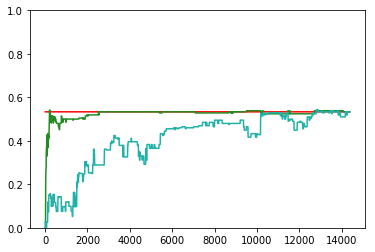

In [80]:
plt.plot(q_qbc_mix, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 1.3.2. Only Logistic Regression

In [81]:
alg='onlylog'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    LogisticRegression(C=1.0),
                    LogisticRegression(C=0.1),
                ])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5333333333333333
Current progress: 100.0 %
3349.686285018921


(0, 1)

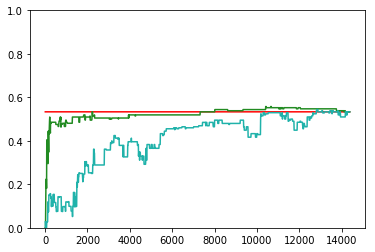

In [84]:
plt.plot(q_qbc_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log,'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)


### 1.3.3. Only Desicion Tree

In [82]:
alg='onlydt'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='gini')),
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='entropy')),
                ])
model=SklearnProbaAdapter(tree.DecisionTreeClassifier('gini'))
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_dt, iter_qbc_dt, f1score_qbc_dt, tn_qbc_dt, fp_qbc_dt,fn_qbc_dt, tp_qbc_dt, k_qbc_dt, trn_dss_qbc_dt, label_holder_qbc_dt, asked_id_qbc_dt = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7575757575757576
Current progress: 100.0 %
6024.044049024582


(0, 1)

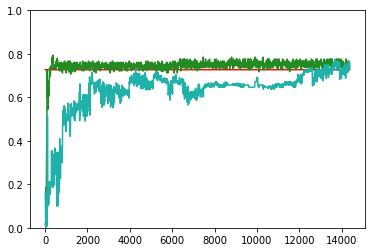

In [85]:
plt.plot(q_qbc_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_dt, f1score_qbc_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 1.3.4. Only Support Vector Machine

In [83]:
alg='onlysvm'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SVM(C=1.0),
                    SVM(C=0.1),
                ])

model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.13333333333333333
Current progress: 100.0 %
20693.757658958435


(0, 1)

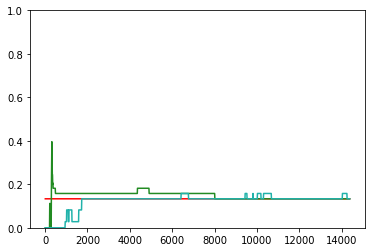

In [103]:
plt.plot(q_qbc_svc, [f1_score_svm] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc,'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

(all plot)

(0, 1)

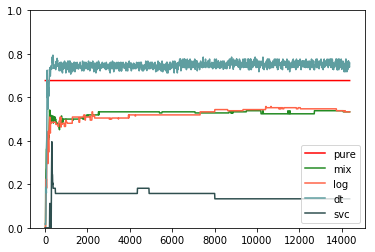

In [105]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_rf, f1score_qbc_log, 'tomato')
plt.plot(q_u_rf, f1score_qbc_dt, 'cadetblue')
plt.plot(q_u_rf, f1score_qbc_svc, 'darkslategray')

plt.legend((('pure','mix','log','dt','svc')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

# 2. USING ONLY LEVENSTEIN

In [106]:
cols = lev_columns_el.copy()

- Modeling Parameters

In [107]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

# filter the train and test according to its columns
X_train = np.array(pd.DataFrame(X_train).iloc[:,get_columns(cols_all, cols)])
X_test = np.array(pd.DataFrame(X_test).iloc[:,get_columns(cols_all, cols)])

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)


In [109]:
run_=10
missing_option='opt4'
features='onlylev'

- Model Results (pure)

In [110]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log, tn_log, fp_log, fn_log, tp_log = get_base_model_result(y_test, y_train, X_test, X_train, ls())
print(f1_score_log)
print(tn_log)
print(fp_log)
print(fn_log)
print(tp_log)

0.23809523809523808
7007
4
60
10


In [111]:
from sklearn.svm import SVC as support_vector
f1_score_svm, tn_svm, fp_svm, fn_svm, tp_svm = get_base_model_result(y_test, y_train, X_test, X_train, support_vector())
print(f1_score_svm)
print(tn_svm)
print(fp_svm)
print(fn_svm)
print(tp_svm)

0.13333333333333333
7011
0
65
5


In [112]:
from sklearn import tree
f1_score_dt, tn_dt, fp_dt, fn_dt, tp_dt = get_base_model_result(y_test, y_train, X_test, X_train, tree.DecisionTreeClassifier())
print(f1_score_dt)
print(tn_dt)
print(fp_dt)
print(fn_dt)
print(tp_dt)

0.7786259541984734
7001
10
19
51


In [113]:
f1_score_rf, tn_rf, fp_rf, fn_rf, tp_rf = get_base_model_result(y_test, y_train, X_test, X_train, RandomForestClassifier())
print(f1_score_rf)
print(tn_rf)
print(fp_rf)
print(fn_rf)
print(tp_rf)

0.7333333333333334
7005
6
26
44


## 2.1. Random Sampling

In [115]:
q_type='random'

## 2.1.1. Logistic Regression

In [116]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.23809523809523808
Current progress: 100.0 %
404.6481900215149


(0, 1)

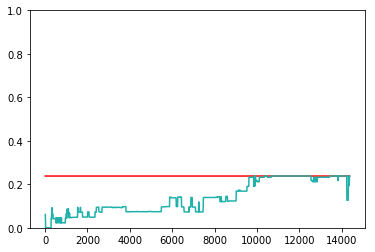

In [117]:
plt.plot(q_u_svm, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)

## 2.1.2. Support Vector Machines

In [118]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.13333333333333333
Current progress: 100.0 %
474.9942011833191


(0, 1)

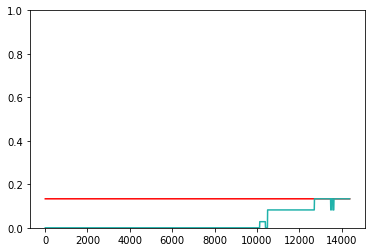

In [119]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)


## 2.1.3. Decision Trees

In [120]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_dt, iter_r_dt, f1score_r_dt, tn_r_dt, fp_r_dt,fn_r_dt, tp_r_dt, k_r_dt, trn_dss_r_dt, label_holder_r_dt, asked_id_r_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7812500000000001
Current progress: 100.0 %
270.8350019454956


(0, 1)

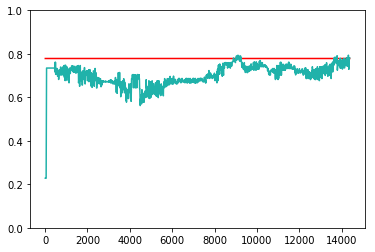

In [121]:
plt.plot(q_u_svm, [f1_score_dt] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)


## 2.1.4. Random Forest Regression

In [122]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_rf, iter_r_rf, f1score_r_rf, tn_r_rf, fp_r_rf,fn_r_rf, tp_r_rf, k_r_rf, trn_dss_r_rf, label_holder_r_rf, asked_id_r_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.6991869918699187
Current progress: 100.0 %
327.71432876586914


(0, 1)

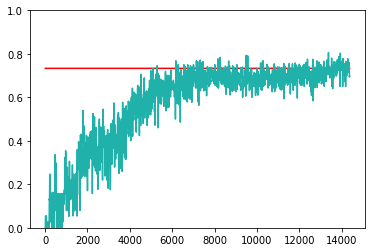

In [123]:
plt.plot(q_u_svm, [f1_score_rf] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

## 2.2. Uncertainity Sampling

In [126]:
q_type='uncertainity'

### 2.2.1. Logistic Regression

In [129]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.23809523809523808
Current progress: 100.0 %
1727.3257319927216


(0, 1)

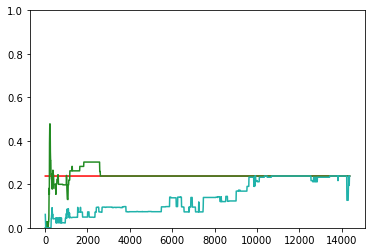

In [131]:
plt.plot(q_u_log, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 2.2.2. Support Vector Machine

In [132]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.13333333333333333
Current progress: 100.0 %
3774.5893638134003


(0, 1)

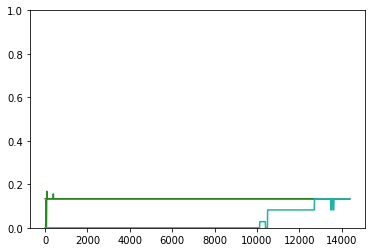

In [133]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 2.2.3. Decision Tree

In [134]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_dt, iter_u_dt, f1score_u_dt, tn_u_dt, fp_u_dt,fn_u_dt, tp_u_dt, k_u_dt, trn_dss_u_dt, label_holder_u_dt, asked_id_u_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7596899224806201
Current progress: 100.0 %
608.9170498847961


(0, 1)

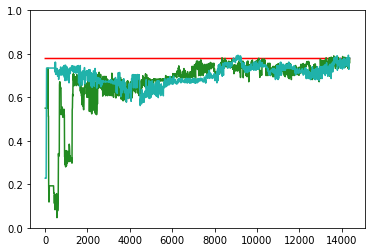

In [135]:
plt.plot(q_u_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_u_dt, f1score_u_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 2.2.4. Random Forest

In [136]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_rf, iter_u_rf, f1score_u_rf, tn_u_rf, fp_u_rf,fn_u_rf, tp_u_rf, k_u_rf, trn_dss_u_rf, label_holder_u_rf, asked_id_u_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7179487179487181
Current progress: 100.0 %
1100.5828812122345


(0, 1)

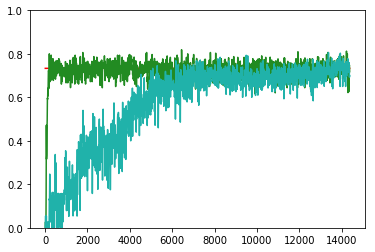

In [137]:

plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_log, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

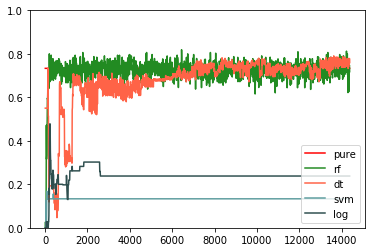

In [150]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_rf, f1score_u_dt, 'tomato')
plt.plot(q_u_rf, f1score_u_svm, 'cadetblue')
plt.plot(q_u_rf, f1score_u_log, 'darkslategray')

plt.legend((('pure','rf','dt','svm','log')),loc='lower right')
#plt.gca().legend(('y0','y1'))
plt.ylim(0, 1)

## 2.2. Density Weighting

In [138]:
q_type='dns'

In [139]:
alg='log'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = DWUS(trn_ds, model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_dns_log, iter_dns_log, f1score_dns_log, tn_dns_log, fp_dns_log,fn_dns_log, tp_dns_log, k_dns_log, trn_dss_dns_log, label_holder_dns_log, asked_id_dns_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.23809523809523808
Current progress: 100.0 %
37134.47258687019


(0, 1)

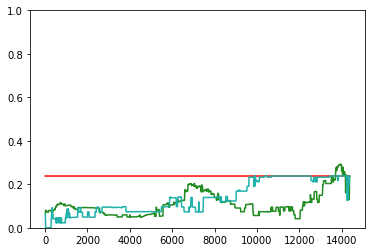

In [140]:
plt.plot(q_dns_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_dns_log, f1score_dns_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

## 2.3. Query by Committee

In [141]:
q_type='qbc'

### 2.3.1. Mix of all the models

In [142]:
alg='mixall'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
    SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM(),])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.23809523809523808
Current progress: 100.0 %
8273.812882900238


(0, 1)

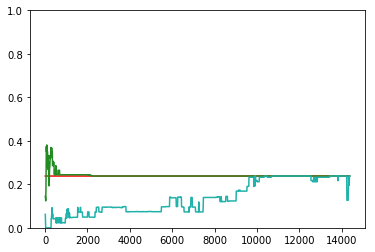

In [143]:
plt.plot(q_qbc_mix, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 2.3.2. Only Logistic Regression

In [144]:
alg='onlylog'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    LogisticRegression(C=1.0),
                    LogisticRegression(C=0.1),
                ])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.23809523809523808
Current progress: 100.0 %
3766.929864883423


(0, 1)

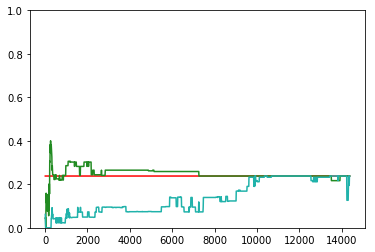

In [145]:
plt.plot(q_qbc_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log,'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)


### 2.3.3. Only Desicion Tree

In [146]:
alg='onlydt'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='gini')),
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='entropy')),
                ])
model=SklearnProbaAdapter(tree.DecisionTreeClassifier('gini'))
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_dt, iter_qbc_dt, f1score_qbc_dt, tn_qbc_dt, fp_qbc_dt,fn_qbc_dt, tp_qbc_dt, k_qbc_dt, trn_dss_qbc_dt, label_holder_qbc_dt, asked_id_qbc_dt = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7786259541984734
Current progress: 100.0 %
2380.0778501033783


(0, 1)

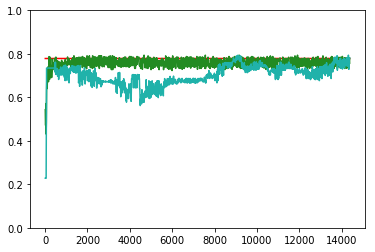

In [147]:
plt.plot(q_qbc_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_dt, f1score_qbc_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 2.3.4. Only Support Vector Machine

In [148]:
alg='onlysvm'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SVM(C=1.0),
                    SVM(C=0.1),
                ])

model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.13333333333333333
Current progress: 100.0 %
22556.368439912796


(0, 1)

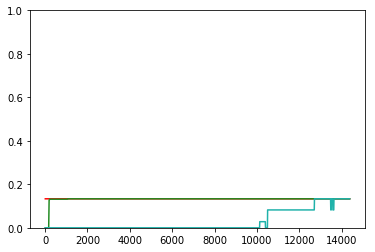

In [149]:
plt.plot(q_qbc_svc, [f1_score_svm] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc,'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

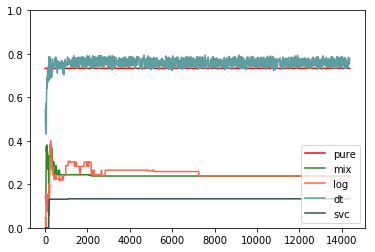

In [151]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_rf, f1score_qbc_log, 'tomato')
plt.plot(q_u_rf, f1score_qbc_dt, 'cadetblue')
plt.plot(q_u_rf, f1score_qbc_svc, 'darkslategray')

plt.legend((('pure','mix','log','dt','svc')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

# 3. USING ONLY JARO-WINKLER

In [152]:
cols = jaro_columns_el.copy()

- Modeling Parameters

In [153]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

# filter the train and test according to its columns
X_train = np.array(pd.DataFrame(X_train).iloc[:,get_columns(cols_all, cols)])
X_test = np.array(pd.DataFrame(X_test).iloc[:,get_columns(cols_all, cols)])

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)

In [154]:
run_=10
missing_option='opt4'
features='onlyjaro'

- Model Results (pure)

In [155]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log, tn_log, fp_log, fn_log, tp_log = get_base_model_result(y_test, y_train, X_test, X_train, ls())
print(f1_score_log)
print(tn_log)
print(fp_log)
print(fn_log)
print(tp_log)

0.028169014084507043
7011
0
69
1


In [156]:
from sklearn.svm import SVC as support_vector
f1_score_svm, tn_svm, fp_svm, fn_svm, tp_svm = get_base_model_result(y_test, y_train, X_test, X_train, support_vector())
print(f1_score_svm)
print(tn_svm)
print(fp_svm)
print(fn_svm)
print(tp_svm)

0.0
7011
0
70
0


In [157]:
from sklearn import tree
f1_score_dt, tn_dt, fp_dt, fn_dt, tp_dt = get_base_model_result(y_test, y_train, X_test, X_train, tree.DecisionTreeClassifier())
print(f1_score_dt)
print(tn_dt)
print(fp_dt)
print(fn_dt)
print(tp_dt)

0.7384615384615385
6999
12
22
48


In [158]:
f1_score_rf, tn_rf, fp_rf, fn_rf, tp_rf = get_base_model_result(y_test, y_train, X_test, X_train, RandomForestClassifier())
print(f1_score_rf)
print(tn_rf)
print(fp_rf)
print(fn_rf)
print(tp_rf)


0.6785714285714285
7007
4
32
38


## 3.1. Random Sampling

In [159]:
q_type='random'

### 3.1.1. Logistic Regression

In [163]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.028169014084507043
Current progress: 100.0 %
406.48679780960083


(0, 1)

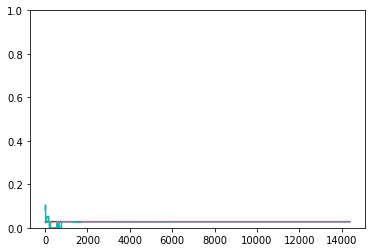

In [164]:
plt.plot(q_u_svm, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)


### 3.1.2. Support Vector Machine

In [165]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.0
Current progress: 100.0 %
546.5119757652283


(0, 1)

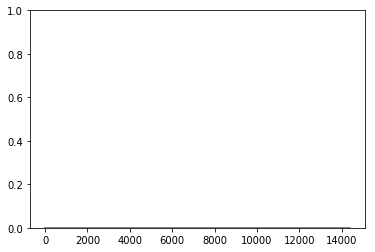

In [166]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)


### 3.1.3. Decision Tree

In [167]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_dt, iter_r_dt, f1score_r_dt, tn_r_dt, fp_r_dt,fn_r_dt, tp_r_dt, k_r_dt, trn_dss_r_dt, label_holder_r_dt, asked_id_r_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7462686567164178
Current progress: 100.0 %
313.35386180877686


(0, 1)

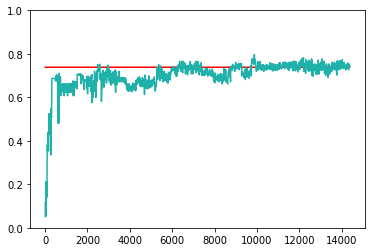

In [168]:
plt.plot(q_u_svm, [f1_score_dt] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)


### 3.1.4. Random Forest

In [169]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_rf, iter_r_rf, f1score_r_rf, tn_r_rf, fp_r_rf,fn_r_rf, tp_r_rf, k_r_rf, trn_dss_r_rf, label_holder_r_rf, asked_id_r_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.6666666666666666
Current progress: 100.0 %
350.6579587459564


(0, 1)

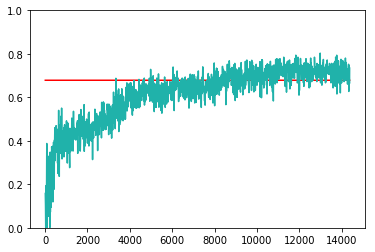

In [170]:
plt.plot(q_u_svm, [f1_score_rf] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)


## 3.2. Uncertainity Sampling

In [171]:
q_type='uncertainity'

### 3.2.1. Logistic Regression

In [172]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.028169014084507043
Current progress: 100.0 %
1720.0682349205017


(0, 1)

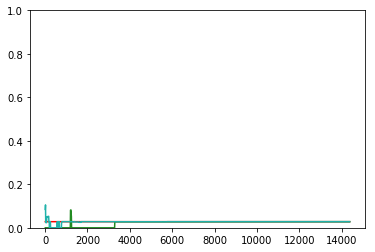

In [174]:
plt.plot(q_u_log, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 3.2.2. Support Vector Machine

In [175]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.0
Current progress: 100.0 %
3967.1761558055878


(0, 1)

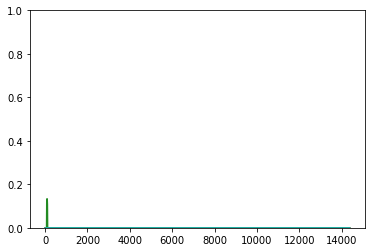

In [176]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 3.2.3. Decision Tree

In [177]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_dt, iter_u_dt, f1score_u_dt, tn_u_dt, fp_u_dt,fn_u_dt, tp_u_dt, k_u_dt, trn_dss_u_dt, label_holder_u_dt, asked_id_u_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7575757575757576
Current progress: 100.0 %
652.3898198604584


(0, 1)

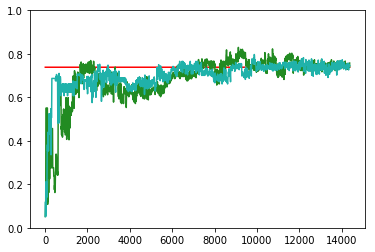

In [178]:
plt.plot(q_u_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_u_dt, f1score_u_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 3.2.4. Random Forest

In [179]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_rf, iter_u_rf, f1score_u_rf, tn_u_rf, fp_u_rf,fn_u_rf, tp_u_rf, k_u_rf, trn_dss_u_rf, label_holder_u_rf, asked_id_u_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.6964285714285714
Current progress: 100.0 %
1204.7035188674927


(0, 1)

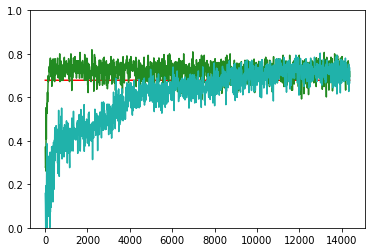

In [180]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_log, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)


(all models)

(0, 1)

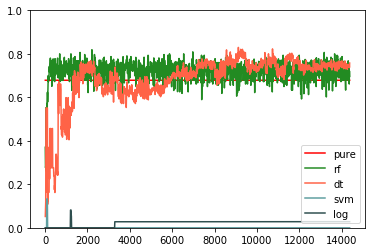

In [186]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_rf, f1score_u_dt, 'tomato')
plt.plot(q_u_rf, f1score_u_svm, 'cadetblue')
plt.plot(q_u_rf, f1score_u_log, 'darkslategray')

plt.legend((('pure','rf','dt','svm','log')),loc='lower right')
#plt.gca().legend(('y0','y1'))
plt.ylim(0, 1)

## 3.2. Density Weighting

In [181]:
q_type='dns'

### 3.2.1. Logistic Regression

In [182]:
alg='log'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = DWUS(trn_ds, model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_dns_log, iter_dns_log, f1score_dns_log, tn_dns_log, fp_dns_log,fn_dns_log, tp_dns_log, k_dns_log, trn_dss_dns_log, label_holder_dns_log, asked_id_dns_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.028169014084507043
Current progress: 100.0 %
38851.88618683815


(0, 1)

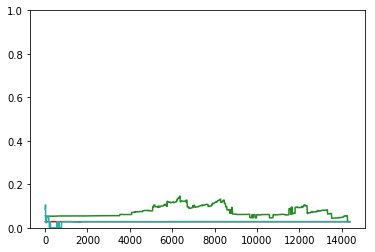

In [183]:
plt.plot(q_dns_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_dns_log, f1score_dns_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

## 3.3. Query by Committee

In [184]:
q_type='qbc'

### 3.3.1. Mix of all the models

In [185]:
alg='mixall'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
    SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM(),])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.028169014084507043
Current progress: 100.0 %
6681.696271181107


(0, 1)

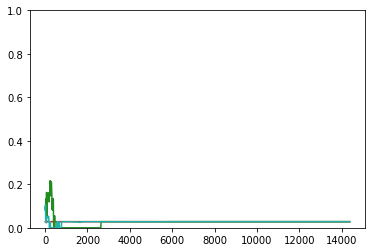

In [187]:
plt.plot(q_qbc_mix, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 3.3.2. Only Logistic Regression

In [188]:
alg='onlylog'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    LogisticRegression(C=1.0),
                    LogisticRegression(C=0.1),
                ])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.028169014084507043
Current progress: 100.0 %
3732.2292659282684


(0, 1)

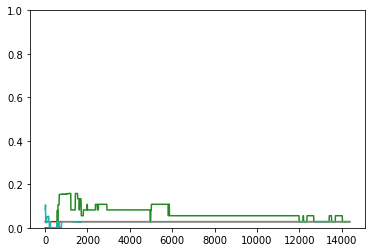

In [189]:
plt.plot(q_qbc_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log,'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)


### 3.3.3. Only Desicion Tree

In [190]:
alg='onlydt'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='gini')),
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='entropy')),
                ])
model=SklearnProbaAdapter(tree.DecisionTreeClassifier('gini'))
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_dt, iter_qbc_dt, f1score_qbc_dt, tn_qbc_dt, fp_qbc_dt,fn_qbc_dt, tp_qbc_dt, k_qbc_dt, trn_dss_qbc_dt, label_holder_qbc_dt, asked_id_qbc_dt = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7407407407407408
Current progress: 100.0 %
2145.3641550540924


(0, 1)

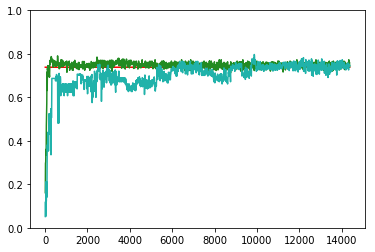

In [191]:
plt.plot(q_qbc_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_dt, f1score_qbc_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 3.3.4. Only Support Vector Machine

In [192]:
alg='onlysvm'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SVM(C=1.0),
                    SVM(C=0.1),
                ])

model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.0
Current progress: 100.0 %
5613.360109090805


(0, 1)

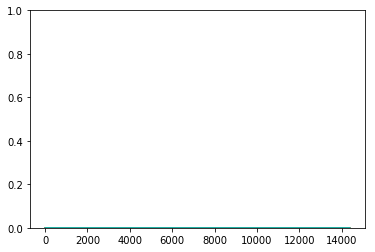

In [193]:
plt.plot(q_qbc_svc, [f1_score_svm] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc,'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

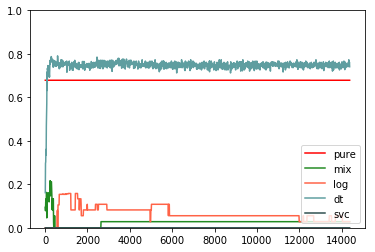

In [194]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_rf, f1score_qbc_log, 'tomato')
plt.plot(q_u_rf, f1score_qbc_dt, 'cadetblue')
plt.plot(q_u_rf, f1score_qbc_svc, 'darkslategray')

plt.legend((('pure','mix','log','dt','svc')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

# 4. ALL FEATURES

In [196]:
run_=10
missing_option='opt4'
features='all'

In [197]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)


- Model Results (pure)

In [202]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log, tn_log, fp_log, fn_log, tp_log = get_base_model_result(y_test, y_train, X_test, X_train, ls())
print(f1_score_log)
print(tn_log)
print(fp_log)
print(fn_log)
print(tp_log)

0.5555555555555555
7003
8
40
30


In [203]:
from sklearn.svm import SVC as support_vector
f1_score_svm, tn_svm, fp_svm, fn_svm, tp_svm = get_base_model_result(y_test, y_train, X_test, X_train, support_vector())
print(f1_score_svm)
print(tn_svm)
print(fp_svm)
print(fn_svm)
print(tp_svm)

0.13333333333333333
7011
0
65
5


In [204]:
from sklearn import tree
f1_score_dt, tn_dt, fp_dt, fn_dt, tp_dt = get_base_model_result(y_test, y_train, X_test, X_train, tree.DecisionTreeClassifier())
print(f1_score_dt)
print(tn_dt)
print(fp_dt)
print(fn_dt)
print(tp_dt)

0.7244094488188977
7000
11
24
46


In [205]:
f1_score_rf, tn_rf, fp_rf, fn_rf, tp_rf = get_base_model_result(y_test, y_train, X_test, X_train, RandomForestClassifier())
print(f1_score_rf)
print(tn_rf)
print(fp_rf)
print(fn_rf)
print(tp_rf)

0.7575757575757576
6999
12
20
50


## 4.1. Random Sampling

In [206]:
q_type='random'

## 4.1.1. Logistic Regression

In [207]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5555555555555555
Current progress: 100.0 %
636.6145961284637


(0, 1)

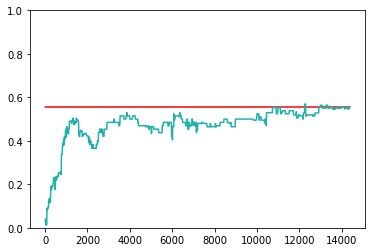

In [208]:
plt.plot(q_u_svm, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)

## 4.1.2. Support Vector Machines

In [209]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.13333333333333333
Current progress: 100.0 %
715.5597109794617


(0, 1)

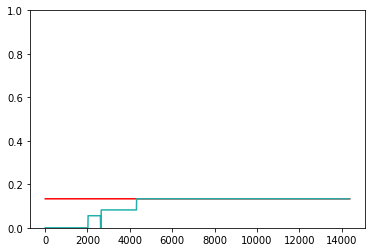

In [210]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)


## 4.1.3. Decision Trees

In [211]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_dt, iter_r_dt, f1score_r_dt, tn_r_dt, fp_r_dt,fn_r_dt, tp_r_dt, k_r_dt, trn_dss_r_dt, label_holder_r_dt, asked_id_r_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7200000000000001
Current progress: 100.0 %
335.6001651287079


(0, 1)

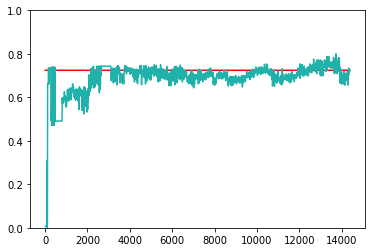

In [212]:
plt.plot(q_u_svm, [f1_score_dt] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)


## 4.1.4. Random Forest Regression

In [213]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = RandomSampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_r_rf, iter_r_rf, f1score_r_rf, tn_r_rf, fp_r_rf,fn_r_rf, tp_r_rf, k_r_rf, trn_dss_r_rf, label_holder_r_rf, asked_id_r_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)


14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7538461538461538
Current progress: 100.0 %
369.3067147731781


(0, 1)

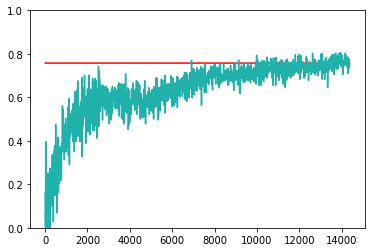

In [214]:
plt.plot(q_u_svm, [f1_score_rf] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

## 4.2. Uncertainity Sampling

In [215]:
q_type='uncertainity'

### 4.2.1. Logistic Regression

In [216]:
alg='log'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5555555555555555
Current progress: 100.0 %
3695.2900223731995


(0, 1)

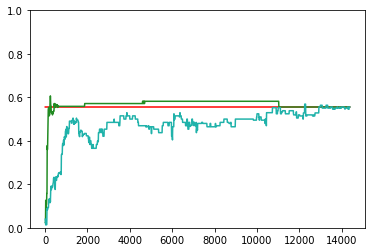

In [217]:
plt.plot(q_u_log, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 4.2.2. Support Vector Machine

In [218]:
alg='svm'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method='lc', model=SVM())
model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm = run_faster(trn_ds, tst_ds, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.13333333333333333
Current progress: 100.0 %
7539.507874011993


(0, 1)

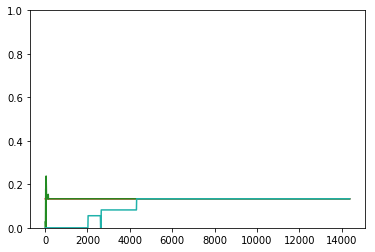

In [219]:
plt.plot(q_u_svm, [f1_score_svm] * (len(q_u_log)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

### 4.2.3. Decision Tree

In [220]:
alg='dt'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(tree.DecisionTreeClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_dt, iter_u_dt, f1score_u_dt, tn_u_dt, fp_u_dt,fn_u_dt, tp_u_dt, k_u_dt, trn_dss_u_dt, label_holder_u_dt, asked_id_u_dt = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.71875
Current progress: 100.0 %
967.9502992630005


(0, 1)

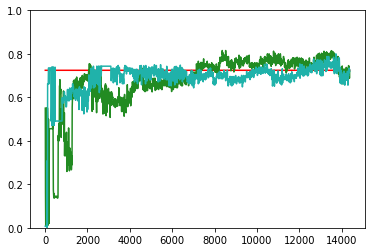

In [221]:
plt.plot(q_u_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_u_dt, f1score_u_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 4.2.4. Random Forest

In [222]:
alg='rf'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
model_dec=SklearnProbaAdapter(RandomForestClassifier())
qs = UncertaintySampling(trn_ds, method='lc', model=model_dec)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
q_u_rf, iter_u_rf, f1score_u_rf, tn_u_rf, fp_u_rf,fn_u_rf, tp_u_rf, k_u_rf, trn_dss_u_rf, label_holder_u_rf, asked_id_u_rf = run_faster(trn_ds, tst_ds, y_train, model_dec, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7627118644067797
Current progress: 100.0 %
1479.7834298610687


(0, 1)

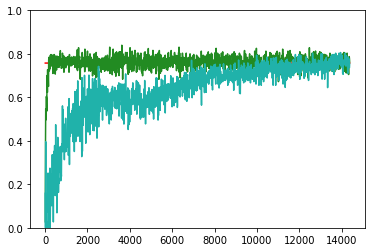

In [223]:

plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_log, f1score_r_rf, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

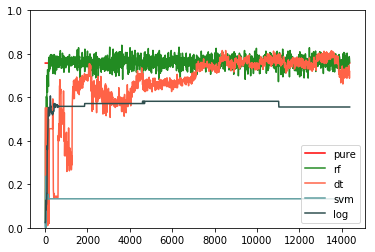

In [224]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_u_rf, 'forestgreen')
plt.plot(q_u_rf, f1score_u_dt, 'tomato')
plt.plot(q_u_rf, f1score_u_svm, 'cadetblue')
plt.plot(q_u_rf, f1score_u_log, 'darkslategray')

plt.legend((('pure','rf','dt','svm','log')),loc='lower right')
#plt.gca().legend(('y0','y1'))
plt.ylim(0, 1)

## 4.2. Density Weighting

In [228]:
q_type='dns'

In [229]:
alg='log'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = DWUS(trn_ds, model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_dns_log, iter_dns_log, f1score_dns_log, tn_dns_log, fp_dns_log,fn_dns_log, tp_dns_log, k_dns_log, trn_dss_dns_log, label_holder_dns_log, asked_id_dns_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5555555555555555
Current progress: 100.0 %
160542.93913912773


(0, 1)

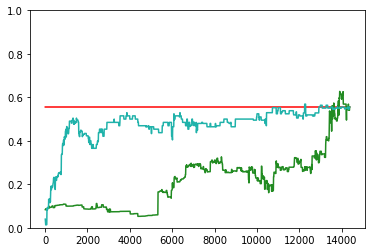

In [230]:
plt.plot(q_dns_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_dns_log, f1score_dns_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

## 4.3. Query by Committee

In [231]:
q_type='qbc'

### 4.3.1. Mix of all the models

In [232]:
alg='mixall'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
    SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM(),])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5555555555555555
Current progress: 100.0 %
12541.777621746063


(0, 1)

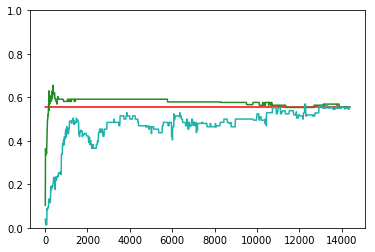

In [233]:
plt.plot(q_qbc_mix, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 4.3.2. Only Logistic Regression

In [234]:
alg='onlylog'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    LogisticRegression(C=1.0),
                    LogisticRegression(C=0.1),
                ])

model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.5555555555555555
Current progress: 100.0 %
6280.990026950836


(0, 1)

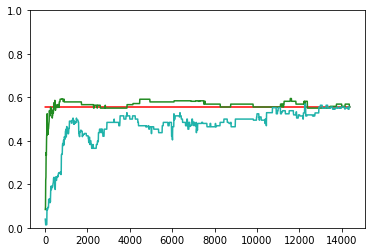

In [235]:
plt.plot(q_qbc_log, [f1_score_log] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log,'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)


### 4.3.3. Only Desicion Tree

In [236]:
alg='onlydt'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='gini')),
                    SklearnProbaAdapter(tree.DecisionTreeClassifier(criterion='entropy')),
                ])
model=SklearnProbaAdapter(tree.DecisionTreeClassifier('gini'))
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_dt, iter_qbc_dt, f1score_qbc_dt, tn_qbc_dt, fp_qbc_dt,fn_qbc_dt, tp_qbc_dt, k_qbc_dt, trn_dss_qbc_dt, label_holder_qbc_dt, asked_id_qbc_dt = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.7142857142857142
Current progress: 100.0 %
2724.9011471271515


(0, 1)

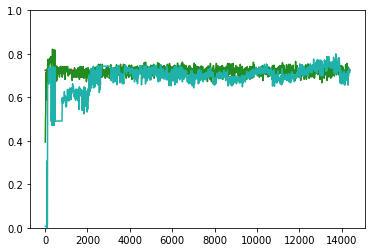

In [237]:
plt.plot(q_qbc_dt, [f1_score_dt] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_dt, f1score_qbc_dt, 'forestgreen')
plt.plot(q_u_log, f1score_r_dt, 'lightseagreen')
plt.ylim(0, 1)

### 4.3.4. Only Support Vector Machine

In [238]:
alg='onlysvm'
quota = len(y_train) - seed
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=[
                    SVM(C=1.0),
                    SVM(C=0.1),
                ])

model = SVM()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc = run_faster(trn_ds, tst_ds, y_train, model, qs,X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.13333333333333333
Current progress: 100.0 %
10829.713228702545


(0, 1)

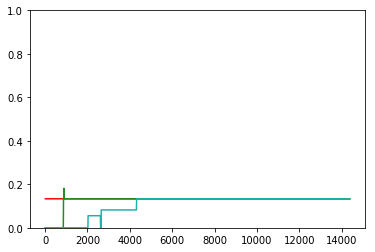

In [239]:
plt.plot(q_qbc_svc, [f1_score_svm] * (len(q_u_dt)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc,'forestgreen')
plt.plot(q_u_log, f1score_r_svm, 'lightseagreen')
plt.ylim(0, 1)

(all models)

(0, 1)

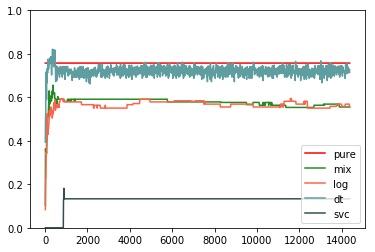

In [240]:
plt.plot(q_u_rf, [f1_score_rf] * (len(q_u_rf)), '-r')
plt.plot(q_u_rf, f1score_qbc_mix, 'forestgreen')
plt.plot(q_u_rf, f1score_qbc_log, 'tomato')
plt.plot(q_u_rf, f1score_qbc_dt, 'cadetblue')
plt.plot(q_u_rf, f1score_qbc_svc, 'darkslategray')

plt.legend((('pure','mix','log','dt','svc')),loc='lower right')
#plt.gca().legend(('y0','y1'))


plt.ylim(0, 1)

# 5. FEATURE SELECTION

- Modeling Parameters

In [24]:
run_=10
missing_option='opt4'
features='fet_select'

In [25]:
# take all the columns
p_result_nomiss_jac=df2[cols_all]
# do train, test split
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)
seed=10
# get the seeds from clusters
samp=get_seed_cluster(y_train, X_train, seed)[0]

trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds = Dataset(X_test, y_test)


- Model results (choose features) -> F-Classification

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif


X_new = SelectKBest(f_classif, k=20).fit(X_train, y_train)
mask = X_new.get_support() #list of booleans
new_features_f = [] # The list of your K best features

for bool, feature in zip(mask, cols_all):
    if bool:
        new_features_f.append(feature)

col_index=[cols_all.index(i) for i in new_features_f]
X_test_feature=[i[col_index] for i in X_test]
X_train_feature=[i[col_index] for i in X_train]

In [28]:
new_features_f

['jac_phone_type',
 'jac_brand',
 'jac_computer_operating_system',
 'jac_height',
 'jac_display_size',
 'jac_weight',
 'jac_memory',
 'jac_rear_cam_resolution',
 'jac_front_cam_resolution',
 'jac_ram',
 'lev_phone_type',
 'lev_brand',
 'lev_display_size',
 'lev_memory',
 'lev_rear_cam_resolution',
 'jaro_phone_type',
 'jaro_brand',
 'jaro_display_size',
 'jaro_memory',
 'jaro_rear_cam_resolution']

In [29]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log_fclass, tn_log_fclass, fp_log_fclass, fn_log_fclass, tp_log_fclass = get_base_model_result(y_test, y_train, X_test_feature, X_train_feature, ls())
print(f1_score_log_fclass)
print(tn_log_fclass)
print(fp_log_fclass)
print(fn_log_fclass)
print(tp_log_fclass)

0.5818181818181818
7003
8
38
32


In [50]:
from sklearn.svm import SVC as support_vector
f1_score_svm_fclass, tn_svm_fclass, fp_svm_fclass, fn_svm_fclass, tp_svm_fclass = get_base_model_result(y_test, y_train, X_test_feature, X_train_feature, support_vector())
print(f1_score_svm_fclass)
print(tn_svm_fclass)
print(fp_svm_fclass)
print(fn_svm_fclass)
print(tp_svm_fclass)

0.2857142857142857
7009
2
58
12


In [31]:
from sklearn import tree
f1_score_dt_fclass, tn_dt_fclass, fp_dt_fclass, fn_dt_fclass, tp_dt_fclass = get_base_model_result(y_test, y_train, X_test_feature, X_train_feature, tree.DecisionTreeClassifier())
print(f1_score_dt_fclass)
print(tn_dt_fclass)
print(fp_dt_fclass)
print(fn_dt_fclass)
print(tp_dt_fclass)

0.7246376811594202
6993
18
20
50


In [32]:
f1_score_rf_fclass, tn_rf_fclass, fp_rf_fclass, fn_rf_fclass, tp_rf_fclass = get_base_model_result(y_test, y_train, X_test_feature, X_train_feature, RandomForestClassifier())
print(f1_score_rf_fclass)
print(tn_rf_fclass)
print(fp_rf_fclass)
print(fn_rf_fclass)
print(tp_rf_fclass)

0.7101449275362319
6992
19
21
49


- Hard Code

In [30]:
def feature_selection(X_train, y_train, all_cols, f_class=True):
    if (f_class==True):
        X_new = SelectKBest(f_classif, k=20).fit(X_train, y_train)
    else:
        X_new = SelectKBest(mutual_info_classif, k=20).fit(X_train, y_train)
    
    mask = X_new.get_support() #list of booleans
    new_features_f = [] # The list of your K best features

    for bool, feature in zip(mask, all_cols):
        if bool:
            new_features_f.append(feature)

    col_index=[all_cols.index(i) for i in new_features_f]
    
    return col_index,new_features_f

In [31]:
def run_featureselection(trn_dss, tst_ds, y_train, model, method_, qs, X_test, y_test, all_cols, save_name, save, type_, part=20):
    # the main active learning algorithm
    E_in, E_out = [], []
    f1score  =[]
    features_ls = []
    label_holder, asked_id = [], []
    tn, fp, fn, tp =[], [], [], []
    
    k= trn_dss.len_labeled()
    k_beg= trn_dss.len_labeled()
    quota = len(trn_dss.data)
    iter_ = 0
    
    while (k<quota):
        clear_output(wait=True)

        # Standard usage of libact objects
        # make_query returns the index of the sample that the active learning algorithm would like to query
        lbls, asks =[],[]
        
        if(part<trn_dss.len_unlabeled()):
            part1=part
        else:
            part1=trn_dss.len_unlabeled()
        
        # -------------------> Feature Selection
        # select features with feature selection
        X_train_feature=[i[0] for i in trn_dss.get_labeled_entries()]
        y_train_feature=[i[1] for i in trn_dss.get_labeled_entries()]
        col_index, features_f=feature_selection(X_train_feature, y_train_feature, all_cols, f_class=True)
        
        features_ls.append(features_f)
        
        # update the X_train dataset and y_train with the current selection of variables
        X_train_updated=[i[0][col_index] for i in trn_dss.data]
        y_train_updated=[i[1] for i in trn_dss.data]
        trn_dss_updated=Dataset(X_train_updated, y_train_updated)
        
        # update X_test 
        X_test_feature=[i[col_index] for i in X_test]    
        
        if(type_=='random'):
            qs = RandomSampling(trn_dss_updated, method=method_, model=model)
            model1=model
        elif(type_=='unc'):
            qs=UncertaintySampling(trn_dss_updated, method=method_, model=model)
            model1=model
        elif(type_=='qbc'):
            qs = QueryByCommittee(trn_dss_updated, models=model)
            model1=method_
        elif(type_=='dens'):
            qs = DWUS(trn_dss_updated, model=model)
            model1=model
        
        for i in range(0,part1):
            # ask id only asks for particular id, not all, everytime
            ask_id=qs.make_query()
            asks.append(ask_id)
            # lbl label returns the label of a given sample
            lb = y_train[ask_id]
            lbls.append(lb)
            # update updates the unlabeled sample with queried sample
            trn_dss.update(ask_id, lb)
            trn_dss_updated.update(ask_id, lb)
            
        label_holder.append(lbls)
        asked_id.append(asks)
        
        # trains only on the labeled examples and chosen values
        model1.train(trn_dss_updated)
        # predict it 
        pred_y=model1.predict(X_test_feature)
        
        # save the results
        f1score.append(f1_score(y_test, pred_y))
        tn.append(confusion_matrix(y_test,pred_y)[0][0])
        fp.append(confusion_matrix(y_test,pred_y)[0][1])
        fn.append(confusion_matrix(y_test,pred_y)[1][0])
        tp.append(confusion_matrix(y_test,pred_y)[1][1])
        
        # score returns the mean accuracy of the results
        #E_in = np.append(E_in, 1 - model.score(trn_dss)) #train
        #E_out = np.append(E_out, 1 - model.score(tst_ds)) #test

        k=trn_dss_updated.len_labeled()
        print(k)
        print(quota)
        print('iteration:', iter_)
        print(len(f1score))
        print('train dataset labeled:', trn_dss.len_labeled())
        print('train dataset shape:',trn_ds.format_sklearn()[0].shape)
        print('train dataset sum:',trn_dss.format_sklearn()[1].sum())
        print('Current f1 score:',f1_score(y_test, pred_y))
        print('Current progress:',np.round(k/quota*100,2),'%')
        print('Chosen_features:',features_f)
        
        # number of iterations
        iter_=iter_+1
        
    if (save==True):
        q= [i for i in range(k_beg,quota,part)]
        iter_=[i for i in range(0,len(f1score))]
        saved_file=pd.DataFrame({'iter':iter_,'quota':q, 'f1_score':f1score,'tn': tn, 'fp':fp, 'fn': fn, 'tp':tp, 'id_index':asked_id,'label':label_holder, 'features':features_ls})
        saved_file.to_csv(save_name)
        
        
    return q, iter_, f1score, tn, fp,fn, tp, k, trn_dss.data, label_holder, asked_id, features_ls


## 5.1. Random Sampling

In [32]:
q_type='random'

In [33]:
run_

10

### 5.1.1. Logistic Regression

In [34]:
alg='log'
model_ = LogisticRegression()
method_='lc'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method=method_, model=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_log, iter_r_log, f1score_r_log, tn_r_log, fp_r_log,fn_r_log, tp_r_log, k_r_log, trn_dss_r_log, label_holder_r_log, asked_id_r_log, featur_log_r = run_featureselection(trn_ds, tst_ds, y_train, model_, method_, qs, X_test, y_test, cols_all, name,True,'random', run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
iteration: 1436
1437
train dataset labeled: 14374
train dataset shape: (14374, 63)
train dataset sum: 148
Current f1 score: 0.5818181818181818
Current progress: 100.0 %
Chosen_features: ['jac_phone_type', 'jac_brand', 'jac_computer_operating_system', 'jac_height', 'jac_display_size', 'jac_weight', 'jac_memory', 'jac_rear_cam_resolution', 'jac_front_cam_resolution', 'jac_ram', 'lev_phone_type', 'lev_brand', 'lev_display_size', 'lev_memory', 'lev_rear_cam_resolution', 'jaro_phone_type', 'jaro_brand', 'jaro_display_size', 'jaro_memory', 'jaro_rear_cam_resolution']
604.16894698143


(0, 1)

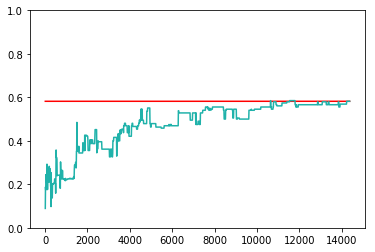

In [75]:
plt.plot(q_r_log, [f1_score_log_fclass] * (len(q_r_log)), '-r')
plt.plot(q_r_log, f1score_r_log,'lightseagreen')
plt.ylim(0, 1)

In [35]:
start_time

1563653214.125577

### 5.1.2. Support Vector Machine

In [76]:
alg='svm'
model_ = SVM()
method_='lc'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = RandomSampling(trn_ds, method=method_, model=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_r_svm, iter_r_svm, f1score_r_svm, tn_r_svm, fp_r_svm,fn_r_svm, tp_r_svm, k_r_svm, trn_dss_r_svm, label_holder_r_svm, asked_id_r_svm, featur_r_svm = run_featureselection(trn_ds, tst_ds, y_train, model_, method_, qs, X_test, y_test, cols_all, name,True,'random', run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
iteration: 1436
1437
train dataset labeled: 14374
train dataset shape: (14374, 63)
train dataset sum: 148
Current f1 score: 0.2857142857142857
Current progress: 100.0 %
Chosen_features: ['jac_phone_type', 'jac_brand', 'jac_computer_operating_system', 'jac_height', 'jac_display_size', 'jac_weight', 'jac_memory', 'jac_rear_cam_resolution', 'jac_front_cam_resolution', 'jac_ram', 'lev_phone_type', 'lev_brand', 'lev_display_size', 'lev_memory', 'lev_rear_cam_resolution', 'jaro_phone_type', 'jaro_brand', 'jaro_display_size', 'jaro_memory', 'jaro_rear_cam_resolution']
754.9646098613739


(0, 1)

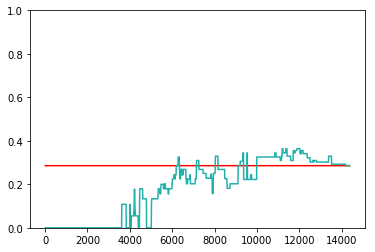

In [77]:
plt.plot(q_r_svm, [f1_score_svm_fclass] * (len(q_r_svm)), '-r')
plt.plot(q_r_svm, f1score_r_svm,'lightseagreen')
plt.ylim(0, 1)

## 5.2. Uncertainty Sampling

In [99]:
q_type='uncertainity'

### 5.2.1. Logistic Regression

In [84]:
alg='log'
model_ = LogisticRegression()
method_='lc'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method=method_, model=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log, featur_log_u = run_featureselection(trn_ds, tst_ds, y_train, model_,method_, qs, X_test, y_test,cols_all,name,True,'unc',run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
iteration: 1436
1437
train dataset labeled: 14374
train dataset shape: (14374, 63)
train dataset sum: 148
Current f1 score: 0.5818181818181818
Current progress: 100.0 %
Chosen_features: ['jac_phone_type', 'jac_brand', 'jac_computer_operating_system', 'jac_height', 'jac_display_size', 'jac_weight', 'jac_memory', 'jac_rear_cam_resolution', 'jac_front_cam_resolution', 'jac_ram', 'lev_phone_type', 'lev_brand', 'lev_display_size', 'lev_memory', 'lev_rear_cam_resolution', 'jaro_phone_type', 'jaro_brand', 'jaro_display_size', 'jaro_memory', 'jaro_rear_cam_resolution']
1689.0757579803467


(0, 1)

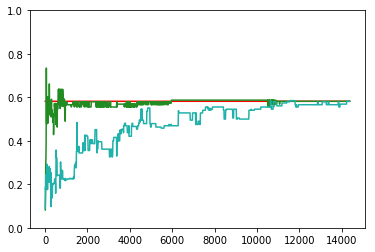

In [94]:
plt.plot(q_u_log, [f1_score_log_fclass] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log, 'forestgreen')
plt.plot(q_u_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 5.1.2. Support Vector Machine

In [111]:
alg='svm'
model_=SVM()
method_='lc'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = UncertaintySampling(trn_ds, method=method_, model=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_svm, iter_u_svm, f1score_u_svm, tn_u_svm, fp_u_svm,fn_u_svm, tp_u_svm, k_u_svm, trn_dss_u_svm, label_holder_u_svm, asked_id_u_svm, featur_log_svm = run_featureselection(trn_ds, tst_ds, y_train, model_,method_, qs, X_test, y_test,cols_all,name,True,'unc',run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
iteration: 1436
1437
train dataset labeled: 14374
train dataset shape: (14374, 63)
train dataset sum: 148
Current f1 score: 0.2857142857142857
Current progress: 100.0 %
Chosen_features: ['jac_phone_type', 'jac_brand', 'jac_computer_operating_system', 'jac_height', 'jac_display_size', 'jac_weight', 'jac_memory', 'jac_rear_cam_resolution', 'jac_front_cam_resolution', 'jac_ram', 'lev_phone_type', 'lev_brand', 'lev_display_size', 'lev_memory', 'lev_rear_cam_resolution', 'jaro_phone_type', 'jaro_brand', 'jaro_display_size', 'jaro_memory', 'jaro_rear_cam_resolution']
3460.8462603092194


(0, 1)

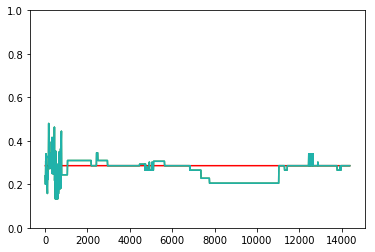

In [112]:
plt.plot(q_u_svm, [f1_score_svm_fclass] * (len(q_u_svm)), '-r')
plt.plot(q_u_svm, f1score_u_svm, 'forestgreen')
plt.plot(q_u_svm, f1score_u_svm, 'lightseagreen')
plt.ylim(0, 1)


## 5.3. Density Weighting

In [113]:
q_type='dns'

In [91]:
alg='log'
model_ = LogisticRegression()
method_='lc'
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = DWUS(trn_ds, model=LogisticRegression())
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_dns_log, iter_dns_log, f1score_dns_log, tn_dns_log, fp_dns_log,fn_dns_log, tp_dns_log, k_dns_log, trn_dss_dns_log, label_holder_dns_log, asked_id_dns_log,featur_log_dns = run_featureselection(trn_ds, tst_ds, y_train, model_,method_, qs, X_test, y_test,cols_all,name,True,'dens',run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
iteration: 1436
1437
train dataset labeled: 14374
train dataset shape: (14374, 63)
train dataset sum: 148
Current f1 score: 0.5818181818181818
Current progress: 100.0 %
Chosen_features: ['jac_phone_type', 'jac_brand', 'jac_computer_operating_system', 'jac_height', 'jac_display_size', 'jac_weight', 'jac_memory', 'jac_rear_cam_resolution', 'jac_front_cam_resolution', 'jac_ram', 'lev_phone_type', 'lev_brand', 'lev_display_size', 'lev_memory', 'lev_rear_cam_resolution', 'jaro_phone_type', 'jaro_brand', 'jaro_display_size', 'jaro_memory', 'jaro_rear_cam_resolution']
34591.51978683472


(0, 1)

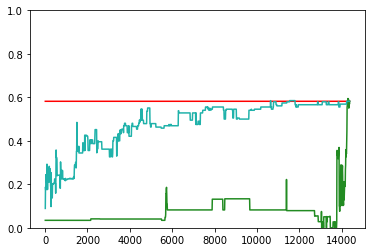

In [67]:
plt.plot(q_dns_log, [f1_score_log_fclass] * (len(q_dns_log)), '-r')
plt.plot(q_dns_log, f1score_dns_log, 'forestgreen')
plt.plot(q_dns_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

## 5.4. Query by Committee

In [37]:
q_type='qbc'

### 5.4.1. Mix of all the models

In [42]:
alg='mixall'
model_= [SklearnProbaAdapter(tree.DecisionTreeClassifier()),
    LogisticRegression(),
    SVM()]
method_=LogisticRegression()
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_mix, iter_qbc_mix, f1score_qbc_mix, tn_qbc_mix, fp_qbc_mix,fn_qbc_mix, tp_qbc_mix, k_qbc_mix, trn_dss_qbc_mix, label_holder_qbc_mix, asked_id_qbc_mix, featur_log_qbc = run_featureselection(trn_ds, tst_ds, y_train, model_,method_, qs,X_test, y_test,cols_all,name,True,'qbc',run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
iteration: 1436
1437
train dataset labeled: 14374
train dataset shape: (14374, 63)
train dataset sum: 148
Current f1 score: 0.5818181818181818
Current progress: 100.0 %
Chosen_features: ['jac_phone_type', 'jac_brand', 'jac_computer_operating_system', 'jac_height', 'jac_display_size', 'jac_weight', 'jac_memory', 'jac_rear_cam_resolution', 'jac_front_cam_resolution', 'jac_ram', 'lev_phone_type', 'lev_brand', 'lev_display_size', 'lev_memory', 'lev_rear_cam_resolution', 'jaro_phone_type', 'jaro_brand', 'jaro_display_size', 'jaro_memory', 'jaro_rear_cam_resolution']
13875.607241153717


(0, 1)

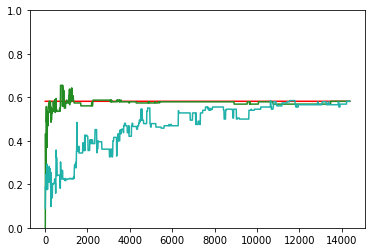

In [57]:
plt.plot(q_qbc_mix, [f1_score_log_fclass] * (len(q_qbc_mix)), '-r')
plt.plot(q_qbc_mix, f1score_qbc_mix, 'forestgreen')
plt.plot(q_qbc_mix, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 5.4.2. Only Logistic Regression

In [39]:
alg='log'
model_= [LogisticRegression(C=1.0),
        LogisticRegression(C=0.1)]
method_=LogisticRegression()
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_log, iter_qbc_log, f1score_qbc_log, tn_qbc_log, fp_qbc_log,fn_qbc_log, tp_qbc_log, k_qbc_log, trn_dss_qbc_log, label_holder_qbc_log, asked_id_qbc_log, featur_loglog_qbc = run_featureselection(trn_ds, tst_ds, y_train, model_, method_,qs,X_test, y_test,cols_all,name,True,'qbc',run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
iteration: 1436
1437
train dataset labeled: 14374
train dataset shape: (14374, 63)
train dataset sum: 148
Current f1 score: 0.5818181818181818
Current progress: 100.0 %
Chosen_features: ['jac_phone_type', 'jac_brand', 'jac_computer_operating_system', 'jac_height', 'jac_display_size', 'jac_weight', 'jac_memory', 'jac_rear_cam_resolution', 'jac_front_cam_resolution', 'jac_ram', 'lev_phone_type', 'lev_brand', 'lev_display_size', 'lev_memory', 'lev_rear_cam_resolution', 'jaro_phone_type', 'jaro_brand', 'jaro_display_size', 'jaro_memory', 'jaro_rear_cam_resolution']
8302.875561952591


(0, 1)

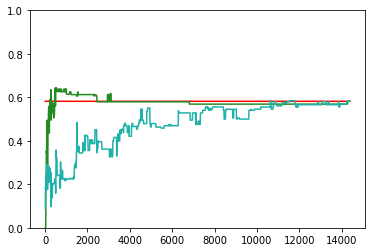

In [58]:
plt.plot(q_qbc_log, [f1_score_log_fclass] * (len(q_qbc_log)), '-r')
plt.plot(q_qbc_log, f1score_qbc_log, 'forestgreen')
plt.plot(q_qbc_log, f1score_r_log, 'lightseagreen')
plt.ylim(0, 1)

### 5.4.3. Only Support Vector Machine

In [41]:
alg='svm'
model_= [SVM(C=1.0),
         SVM(C=0.1)]
method_=SVM()
start_time = time.time()
trn_ds = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
qs = QueryByCommittee(trn_ds, models=model_)
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_qbc_svc, iter_qbc_svc, f1score_qbc_svc, tn_qbc_svc, fp_qbc_svc,fn_qbc_svc, tp_qbc_svc, k_qbc_svc, trn_dss_qbc_svc, label_holder_qbc_svc, asked_id_qbc_svc, featur_svm_qbc = run_featureselection(trn_ds, tst_ds, y_train, model_, method_, qs, X_test, y_test,cols_all,name,True,'qbc',run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
iteration: 1436
1437
train dataset labeled: 14374
train dataset shape: (14374, 63)
train dataset sum: 148
Current f1 score: 0.2857142857142857
Current progress: 100.0 %
Chosen_features: ['jac_phone_type', 'jac_brand', 'jac_computer_operating_system', 'jac_height', 'jac_display_size', 'jac_weight', 'jac_memory', 'jac_rear_cam_resolution', 'jac_front_cam_resolution', 'jac_ram', 'lev_phone_type', 'lev_brand', 'lev_display_size', 'lev_memory', 'lev_rear_cam_resolution', 'jaro_phone_type', 'jaro_brand', 'jaro_display_size', 'jaro_memory', 'jaro_rear_cam_resolution']
14651.601328849792


(0, 1)

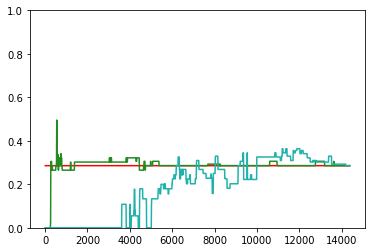

In [60]:
plt.plot(q_qbc_svc, [f1_score_svm_fclass] * (len(q_qbc_log)), '-r')
plt.plot(q_qbc_svc, f1score_qbc_svc, 'forestgreen')
plt.plot(q_qbc_svc, f1score_r_svc, 'lightseagreen')
plt.ylim(0, 1)